# ❄️ Analyse av værdata med Frost API
I denne notebooken gjennomføres en analyse av historiske værdata fra Frost API, levert av Meteorologisk institutt (MET Norge). Gjennom å hente inn, rense og analysere slike data kan vi få innsikt i klimaendringer og deres mulige miljøpåvirkninger.

Notebooken dokumenterer hele arbeidsflyten for Frost-delen av prosjektet - fra datainnhenting via API-et, til klargjøring og analyse av de rensende dataene. Helt til slutt gjennomføres en prediksjon på bakgrunn av den innhentede dataen.

### Datakilde: Frost API

**Kilde**: [frost.met.no](https://frost.met.no/)  
**Leverandør**: Meteorologisk institutt  
**Datakvalitet**: Høy – dataene er levert av en offentlig, autoritativ kilde  
**Tilgjengelighet**: Åpen (krever gratis API-nøkkel)  
**Brukervennlighet**: God, med velstrukturert dokumentasjon og REST-endepunkter  

Valget av Frost API er basert på følgende kriterier:

- Kildeautoritet: Norsk Meteorologisk institutt er en nasjonal myndighet.
- Datakvalitet: Sanntidsdata og historiske data av høy presisjon.
- Tilgjengelighet: Åpent tilgjengelig for forsknings- og analyseformål.
- Brukervennlighet: API-et har god dokumentasjon og støtter JSON-format.





### ☁️ Henting og prosessering av værdata (Frost API)

Først henter vi værdata fra **Frost API**, som tilbys av Meteorologisk institutt. Dataene struktureres og lagres i et egnet format for videre analyse knyttet til klima- og miljøtrender. 


#### Funksjonalitet

1. **Henting av værdata**:
   - Variabler: Temperatur, nedbør og vindhastighet 
   - Stasjon: Oslo - SN18700
   - Periode: 2010-04-01 til 2016-12-30
   - Endepunkt: `https://frost.met.no/observations/v0.jsonld`

2. **Henting av hjelpedata**:
   - Tilgjengelige elementer (`/elements`)
   - Tilgjengelige stasjoner (`/sources`)

3. **Prosessering av data**:
   - Bearbeiding av JSON-respons til strukturert form
   - Filtrering og beregning av daglige verdier:
     - `mean(air_temperature P1D)`
     - `sum(precipitation_amount P1D)`
     - `mean(wind_speed P1D)`

4. **Lagring av data**:
   - Mappe: `../../data/raw_data/`
   - Filnavn: `frostAPI_data.json`

#### Viktige funksjoner

| Funksjon | Beskrivelse |
|---------|-------------|
| `data_frostAPI()` | Koordinerer hele hente- og lagringsprosessen |
| `fetch_weather_data_frostAPI()` | Kaller Frost API, prosesserer og lagrer værdata |
| `get_info_frostAPI()` | Brukes for å inspisere hvilke elementer og stasjoner som er tilgjengelige |

#### Forutsetninger

- Gyldig API-nøkkel fra [Frost API](https://frost.met.no/)
- Python installert med nødvendige pakker: `requests`, `pandas`, `json`, `os`, `pandasql`
- Skrivetilgang til lokal mappe for data: `../../data/raw_data/`


In [37]:
#Importerte biblioteker
import os
import sys
import pandas as pd
import pandasql as psql
from pandasql import sqldf
from dotenv import load_dotenv
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import json



#Globale parametrere for frostAPI
load_dotenv()
client_id = os.getenv('client_id_frost') #henter unik id fra .env fil
from_date = "2010-04-02"
to_date = "2016-12-30"

#Filbane til data
sys.path.insert(0, '../../src/')


In [38]:
# Henter tilgjenglige elementer
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import get_elements_frostAPI
get_elements_frostAPI(client_id)

ID: accumulated(liquid_water_content_of_surface_snow), Navn: Total snow water equivalent
ID: accumulated(precipitation_amount), Navn: Precipitation in gauge
ID: air_pressure, Navn: Air pressure as measured at sensor height
ID: air_pressure_at_sea_level, Navn: Air pressure at sea level
ID: air_pressure_at_sea_level_qnh, Navn: Air pressure (QNH)
ID: air_temperature, Navn: Air temperature
ID: air_temperature_vertical_difference, Navn: Air temperature -vertical diff
ID: altitude, Navn: Altitude
ID: automatic_metar, Navn: Automatic METAR
ID: barometer_temperature, Navn: Temperature of (mercury) barometer
ID: battery_voltage, Navn: Battery voltage
ID: beaufort_wind_force, Navn: Wind force in Beaufort
ID: best_estimate_max(air_temperature P1D), Navn: Homogenised maximum air temperature (24 h)
ID: best_estimate_mean(air_temperature P1D), Navn: Homogenised mean temperature (24 h)
ID: best_estimate_mean(air_temperature P1M), Navn: Homogenised mean temperature (month)
ID: best_estimate_mean(air_t

In [39]:
# Henter tilgjenglige stasjoner med ID
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import get_stations_frostAPI
get_stations_frostAPI(client_id)

ID: SN47230, Navn: ÅKRA UNGDOMSSKOLE
ID: SN20952, Navn: STATFJORD C
ID: SN23670, Navn: E16 RYFOSS
ID: SN59450, Navn: STADLANDET
ID: SN55000, Navn: LUSTER - ORNES
ID: SN12590, Navn: E6 MJØSBRUA
ID: SN26640, Navn: E134 DARBU
ID: SN67650, Navn: FV30 REITSTØA
ID: SN18269, Navn: OSLO - HAUGENSTUA
ID: SN68090, Navn: TRONDHEIM - GRANÅSEN
ID: SN57790, Navn: MYKLEBUSTFJELLET
ID: SN27860, Navn: KVELDE
ID: SN61065, Navn: E136 TRESFJORDBRUA
ID: SN18700, Navn: OSLO - BLINDERN
ID: SN27600, Navn: SANDEFJORD
ID: SN87110, Navn: ANDØYA
ID: SN40250, Navn: VALLE
ID: SN40905, Navn: RV9 BJÅEN
ID: SN27295, Navn: FV307 GRAVDAL
ID: SN43220, Navn: FV44 SÆLEBØ
ID: SN19660, Navn: E16 SKUI
ID: SN18260, Navn: OSLO - HØYBRÅTEN
ID: SN49240, Navn: RV13 LÅTEFOSS
ID: SN77295, Navn: SVENNINGDAL
ID: SN52990, Navn: ORTNEVIK
ID: SN5350, Navn: NORD-ODAL
ID: SN76963, Navn: KRISTINFELTET
ID: SN92170, Navn: OKSFJORD
ID: SN90295, Navn: SESSØYA
ID: SN80740, Navn: REIPÅ
ID: SN490381002, Navn: 300 KV SAUDA – BLÅFALLI-2
ID: SN27564,

In [40]:
# Grupperer og lagrer ønsket data fra frostAPI
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import data_frostAPI
data_frostAPI(client_id)

Gruppert data er lagret under ../../data/raw_data/frostAPI_data.json


### 🧹 Rensing og klargjøring av Frost-data

Videre fokuserer vi på rensing og forberedelse av værdata hentet fra **Frost API**. Målet er å sikre at dataene er konsistente og egnet for videre analyse ved å identifisere og håndtere ekstreme verdier og manglende målinger.

#### Funksjonalitet

##### 1. Visualisering og identifisering av outliers

- Bruker `Pandas` til å beregne:
  - Gjennomsnitt
  - Standardavvik
  - Øvre og nedre grense for avvik (±3 std)
- Plotter distribusjon for hver variabel (`Nedbør`, `Temperatur`, `Vindhastighet`) med `Seaborn` og `Matplotlib`.
- Markerer uteliggere med røde linjer i plottet.

##### 2. Fjerning og interpolering

- Verdier utenfor grenseverdiene erstattes med `NaN`.
- Manglende og fjernede verdier interpoleres for å sikre kontinuitet.
- Resultatet lagres som en ny JSON-fil for videre analyse.

#### Viktige funksjoner

##### `clean_data_frostAPI()`

| Funksjon                | Beskrivelse                                                       |
|------------------------|------------------------------------------------------------------|
| **Laster inn rådata**    | Leser rådata fra `frostAPI_data.json`.                           |
| **Fjerner outliers**     | Kaller `remove_outliers_frost_data` for å identifisere og sette outliers til `NaN`. |
| **Interpolerer manglende verdier** | Bruker `interpolate_and_save_clean_data` for å fylle inn manglende verdier. |
| **Lagrer renset data**  | Lagres som `frostAPI_clean_data.json`.                           |


#### Forutsetninger

- Rådata må være tilgjengelig i: `../../data/raw_data/frostAPI_data.json`
- Python-moduler fra prosjektmappen må være importert:
  - `clean_data_frostAPI()`
- Krever `Pandas`, `Seaborn`, `Matplotlib`, og `sys` for kjøring.
- Resultatene lagres i: `../../data/clean_data/frostAPI_clean_data.json`



Outliers for Nedbør:
Nedbør    62
dtype: int64


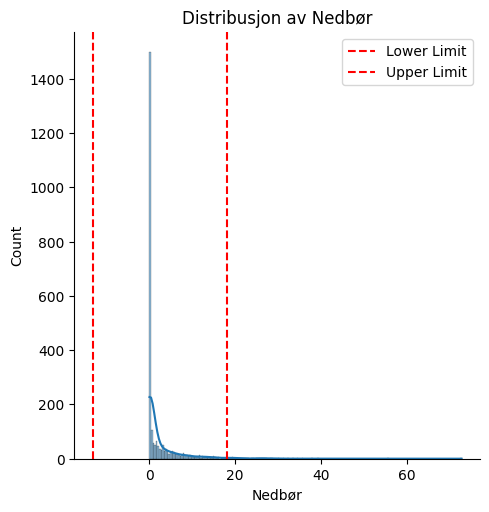


Outliers for Temperatur:
Temperatur    0
dtype: int64


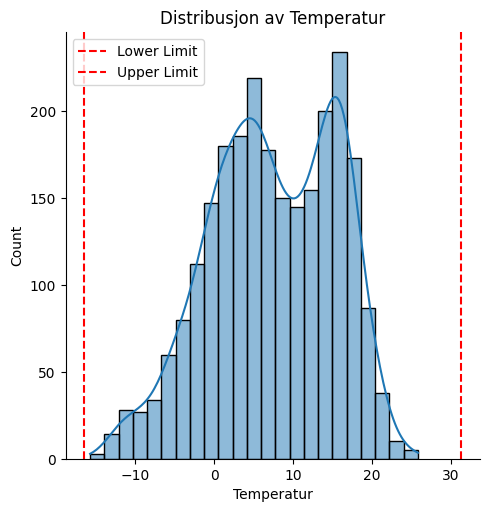


Outliers for Vindhastighet:
Vindhastighet    25
dtype: int64


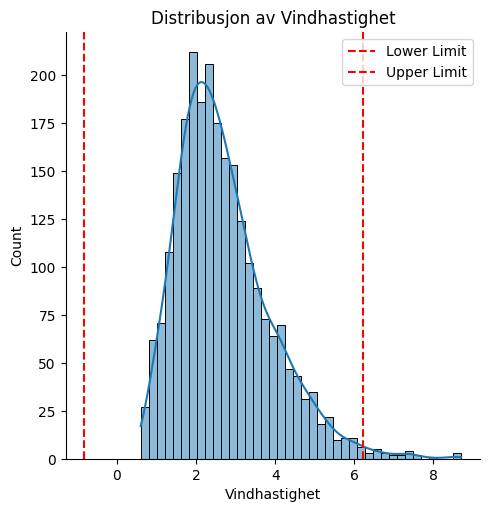

In [41]:
# Analyserer og visualiserer outliers i dataene
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import analyze_frost_data
analyze_frost_data()

In [42]:
# Leser rådata, fjerner outliers, interpolerer manglende verdier og lagrer i clean_data
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import clean_data_frostAPI
clean_data_frostAPI()


Fjerning av outliers:
Outliers er mer enn 3 standardavvik unna gjennomsnittet

Nedbør:
Fjernet 62 outliers
Standardavvik: 5.22
Gjennomsnitt: 2.43

Temperatur:
Fjernet 0 outliers
Standardavvik: 7.95
Gjennomsnitt: 7.43

Vindhastighet:
Fjernet 25 outliers
Standardavvik: 1.18
Gjennomsnitt: 2.71


Interpolering av NaN-verdier:
Nedbør: 63 verdier ble interpolert
Temperatur: 1 verdier ble interpolert
Vindhastighet: 27 verdier ble interpolert

Gruppert data er lagret under ../../data/clean_data/frostAPI_clean_data.json


## ⚖️ Korrigering av skjevhet i værdata

Videre transformerer vi værdata fra Frost API ved å korrigere for skjevhet i fordelingene (ved hjelp av Yeo-Johnson-transformasjon og/eller standardisering). Dette gjør dataene mer symmetriske og bedre egnet for videre analyse og maskinlæring.

#### Funksjonalitet
##### 1. Analyse og korrigering av skjevhet
- Leser inn renset værdata fra frostAPI_clean_data.json.
- Bruker Pandas til å beregne skjevhet (skew()) for hver valgt kolonne.
- Identifiserer kolonner der skjevheten er høyere enn terskelen (±1.0).
- Anvender følgende transformasjoner:
    - **Yeo-Johnson + standardisering** for sterkt skjeve kolonner.
    - **Kun standardisering** for mindre skjeve kolonner.
- Skriver ut skjevhet før og etter transformasjon i konsollen.

##### 2. Lagring av transformerte data
- Resultatet lagres som frostAPI_analyzed_data.json i mappen analyzed_data.
- Filen inneholder de samme kolonnene, men med transformerte og skalerte verdier.
- Dataene er nå egnet for videre analyse og maskinlæring.

#### Viktige funksjoner
`fix_skewness_data_frostAPI()`

| Funksjon                | Beskrivelse                                                       |
|------------------------|------------------------------------------------------------------|
| **Laster inn rensede data**    | Leser renset data fra `frostAPI_clean_data.json`.                           |
| **Analyserer skjevhet**     | `analyse_and_fix_skewness() beregner skjevhet og avgjør transformasjonsmetode. |
| **Transformerer fordelinger og standardiserer data** | Bruker Yeo-johnson og standardisering ved høy skjevhet. Kolonner med lav skjevhet standardiseres direkte. |
| **Lagrer transformerte data**  | Lagres som `frostAPI_analyzed_data.json`.                           |


#### Forutsetninger

- Renset data må være tilgjengelig i: `../../data/clean_data/frostAPI_clean_data.json`
- Python-moduler fra prosjektmappen må være importert:
  - `fix_skewness_data_frostAPI()`
- Krever `Pandas`, `Numpy` og `sys` for kjøring.
- Resultatene lagres i: `../../data/analyzed_data/frostAPI_analyzed_data.json`


In [43]:
# Analyserer og korrigerer skjevhet i dataene og lagrer analyserte data
sys.path.insert(0, '../../src/')
from frostAPI.data_frostAPI import fix_skewness_data_frostAPI
fix_skewness_data_frostAPI()


<function frostAPI.data_frostAPI.fix_skewness_data_frostAPI()>

## 📊 Analyse av værdata fra Frost API (2010-2016)

I denne delen analyserer vi historiske værdata for Oslo over en seksårsperiode (2010–2016), innhentet via Frost API gjennom tidligere steg i prosjektet. Formålet er å identifisere mønstre og trender i temperatur, nedbør og vindhastighet for å få innsikt i mulige klimatiske endringer over tid.

#### Metoder brukt for analyse:
- **PandasSQL** - gir fleksibel og effektiv datafiltrering, gruppering og aggregering 
- ... mer
- ... mer

#### Analysestruktur:
- **Topp 10 varmeste dager** – hvilke dager hadde de høyeste temperaturene, og hva kjennetegner disse dagene med tanke på nedbør og vind, og hvilke år forekom de oftest?
- **Topp 10 kaldeste dager** – hvilke dager hadde de laveste temperaturene, og hvilke år forekom de oftest?
- **Årlig gjennomsnittstemperatur** – ser vi en synkende, stigende eller stabil trend over seksårsperioden?
- **Ukentlige værtrender** – hvordan varierer temperatur, nedbør og vindhastighet gjennom året?
- **Standardavvik** - hvor mye varierer verdiene i datasettet fra gjennomsnittet?

Alle analyser er støttet av visualiseringer og forklares med observasjoner og tolkninger. Dataene er renset og strukturert på forhånd for å sikre nøyaktighet og sammenlignbarhet.

### Analyse av topp 10 dager med høyest temperatur 

*Resultatet viser de ti varmeste dagene i Oslo over 6 år (2010-2016) hvor dataen er hentet fra frostAPI.*

**Observasjoner:**
- Sommeren 2014 var ekstremt varm: hele 9 av 10 varmeste dager forekom i juli 2014. 
- Lav nedbør: 6/10 dager hadde 0 mm nedbør, noe som ofte gir sterk soloppvarming (samsvarer altså med den høye temperaturen).
- Moderat vind: De fleste dagene hadde vindhastigheter på rundt 2 m/s.

**Tolkning:**
Analysen tyder på at 2014 var et unormalt varmt år i Oslo, spesielt i juli. Det høye antallet ekstremt varme dager på rad kan tyde på en varmebølge, som er et fenomen ofte knyttet til klimaendringer og økt global temperatur.

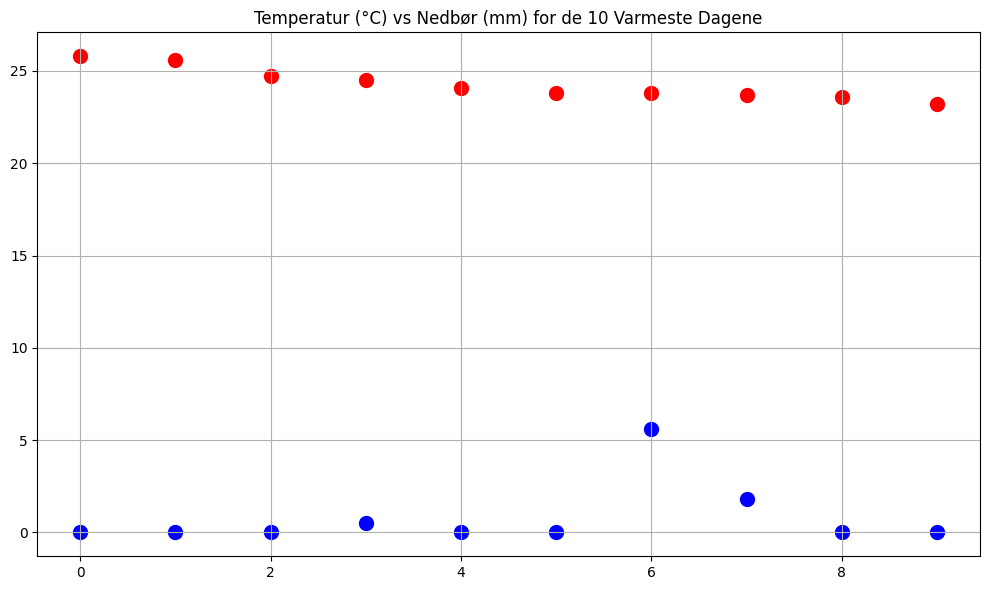

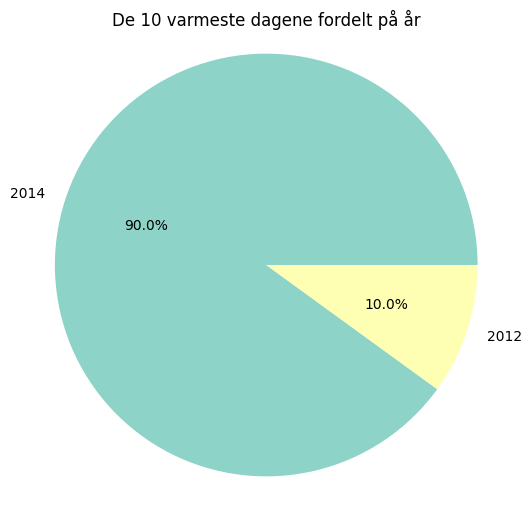

,Dato,Nedbør,Temperatur,Vindhastighet,Interpolert_Nedbør,Interpolert_Temperatur,Interpolert_Vindhastighet,År
0,2014-07-24,0.0,25.8,1.9,0,0,0,2014
1,2014-07-26,0.0,25.6,2.0,0,0,0,2014
2,2014-07-10,0.0,24.7,2.1,0,0,0,2014
3,2014-07-25,0.5,24.5,1.7,0,0,0,2014
4,2014-07-22,0.0,24.1,2.0,0,0,0,2014
5,2012-05-26,0.0,23.8,4.0,0,0,0,2012
6,2014-07-27,5.6,23.8,1.8,0,0,0,2014
7,2014-07-23,1.8,23.7,1.9,0,0,0,2014
8,2014-07-11,0.0,23.6,1.9,0,0,0,2014
9,2014-07-12,0.0,23.2,2.0,0,0,0,2014


In [44]:
# Henter ut og visualiserer de 10 varmeste dagene i datasettet 
#samt setter de i sammenheng med mengde nedbør
sys.path.insert(0, '../../src')
from sql_analysis import analyze_frost_api_clean_data
analyze_frost_api_clean_data()

### Analyse av topp 10 dager med lavest temperatur

*Resultatet viser de ti kaldeste dagene i Oslo over 6 år (2010-2016) hvor dataen er hentet fra frostAPI.*

**Observasjoner:**
- Fire av de 10 kaldeste dagene stammer fra 2010, noe som indikerer en spesielt kald vinter dette året.
- 9/10 av de kaldeste dagene forekom før 2014.

**Tolkning:**
Dataene fra 2010 til 2016 viser at ekstrme kuldedager forekom relativt hyppig i starten av perioden. Etter 2013 avtar dog antall ekstremt kalde dager, og den siste kuldedagen i listen er fra 2016. Dette kan tyde på en tendens mot mildere vintre, og indikere et gradvis varmere klima. 

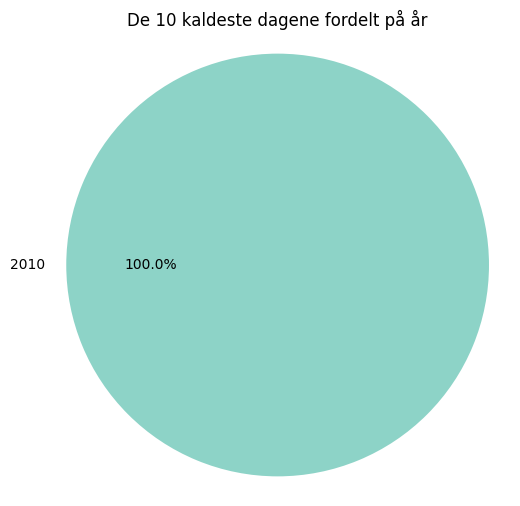

,Dato,Temperatur,År
0,2010-01-01,None,2010
1,2010-01-02,None,2010
2,2010-01-03,None,2010
3,2010-01-04,None,2010
4,2010-01-05,None,2010
5,2010-01-06,None,2010
6,2010-01-07,None,2010
7,2010-01-08,None,2010
8,2010-01-09,None,2010
9,2010-01-10,None,2010


In [45]:
# Henter ut og visualiserer de 10 kaldeste dagene i datasettet
sys.path.insert(0, '../../src')
from sql_analysis import analyze_coldest_frost_api_data
analyze_coldest_frost_api_data()

### Analyse av gjennomsnittlig temperatur per år 

*Resultatet viser gjennnomsnittstemperaturen per år i Oslo over 6 år (2010-2016) hvor dataen er hentet fra frostAPI.*

**Generell trend:**
Gjennomsnittstemperaturen per år i Oslo ser ut til å ha holdt seg relatvit stabilt de siste årene (et stabilt resultat på mellom 6 og 9 grader celcius). Dette kan indikere et relativt stabilit klima uten en klar stigende eller synkende trend over disse årene. 

**Avvik:**
Data for 2010 inkluderer bare perioden fra 1. april og ut året, noe som kan gjøre temperaturen høyere enn normalt årsgrunnlag siden vintermånedene mangler.

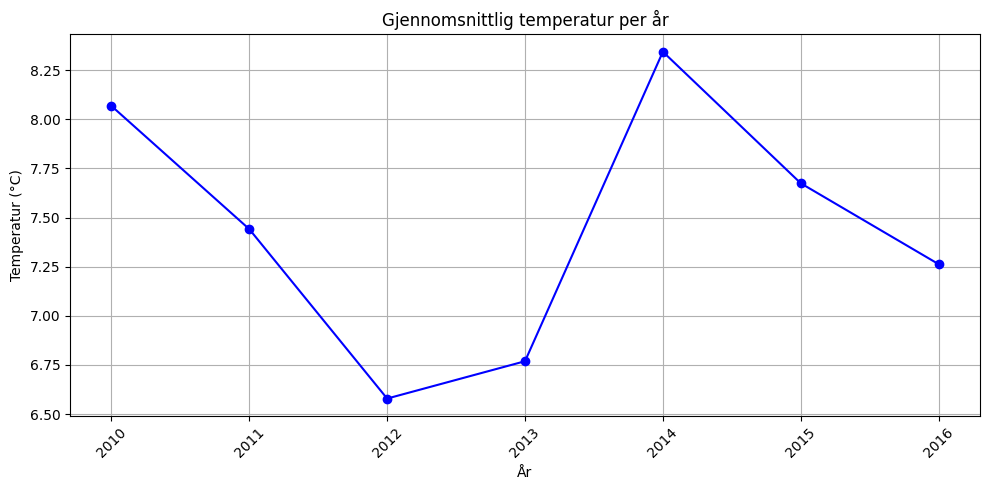

,År,Gjennomsnitt_temperatur
0,2010,8.068613
1,2011,7.441370
2,2012,6.578689
3,2013,6.768767
4,2014,8.344384
5,2015,7.674795
6,2016,7.262842


In [46]:
# Henter ut og visualiserer gjennomsnittlig temperatur per år 
from sql_analysis import analyze_avg_temp_frost_api_data
analyze_avg_temp_frost_api_data()

### Gjennomsnittlig nedbør, temperatur og vindhastighet per uke 

*Viser gjennomsnittlig nedbør, temperatur og vindhastighet per uke i Oslo fra 2010-2016.*


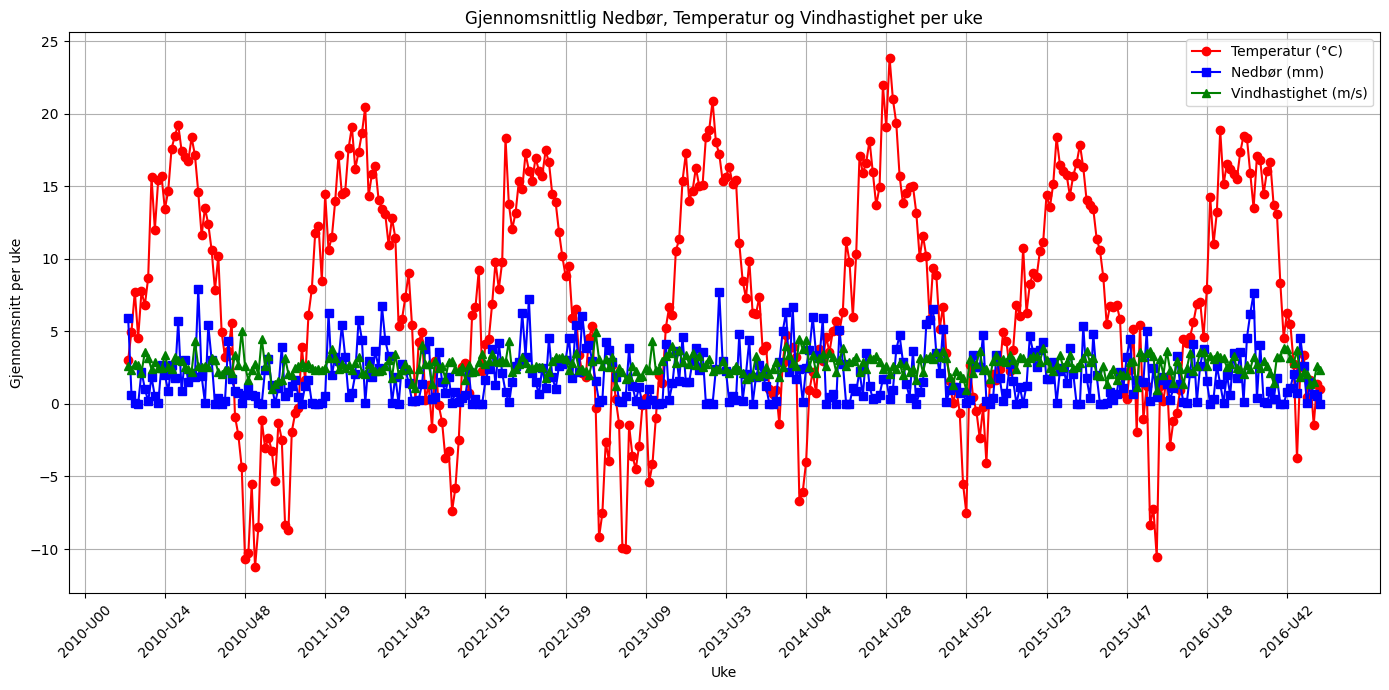

,Uke,Avg_Nedbør,Avg_Temperatur,Avg_Vindhastighet
0,2010-U00,NaN,NaN,NaN
1,2010-U01,NaN,NaN,NaN
2,2010-U02,NaN,NaN,NaN
3,2010-U03,NaN,NaN,NaN
4,2010-U04,NaN,NaN,NaN
...,...,...,...,...
366,2016-U48,0.028571,0.500000,2.028571
367,2016-U49,1.514286,1.657143,1.357143
368,2016-U50,0.671429,-1.428571,1.485714
369,2016-U51,0.571429,1.385714,2.642857


In [47]:
# Henter ut og visualiserer gjennomsnittlig nedbør, temperatur og vindhastighet per uke
from sql_analysis import analyze_weekly_avg_frost_api_data
analyze_weekly_avg_frost_api_data()

### Variasjon i værdata: Standardvik for nedbør, temperatur og vindhastighet

*Regner standardavviket til hele datasettet og standardavvik per uke (frostAPI) for nedbør, temperatur og vindhastighet.*

Standardavvik gir en indikasjon på hvor mye variasjon det er i værdataen.

In [48]:
# Henter ut standardavviket for nedbør, temperatur og vindhastighet for hele datasettet
from sql_analysis import calculate_std_frost_data
calculate_std_frost_data()

,StdDev_Nedbør,StdDev_Temperatur,StdDev_Vindhastighet
0,3.509403,7.947256,1.102797


In [49]:
# Henter ut standardavviket for nedbør, temperatur og vindhastighet per uke
from sql_analysis import calculate_std_frost_weekly
calculate_std_frost_weekly()  

,Uke,StdDev_Nedbør,StdDev_Temperatur,StdDev_Vindhastighet
0,2010-U00,NaN,NaN,NaN
1,2010-U01,NaN,NaN,NaN
2,2010-U02,NaN,NaN,NaN
3,2010-U03,NaN,NaN,NaN
4,2010-U04,NaN,NaN,NaN
...,...,...,...,...
366,2016-U48,2.016178,7.891209,1.387821
367,2016-U49,3.897375,6.821157,1.492694
368,2016-U50,2.009765,9.803375,1.511096
369,2016-U51,1.707648,6.954792,1.296485
